In [1]:
import re
import os
import sys
import json

import jieba

sys.path.append("../../") 
from utils.io import read_csv, write_to, load_json


In [2]:
def strQ2B(ustring):
    """全角转半角"""
    rstring = ""
    for uchar in ustring:
        inside_code=ord(uchar)
        if inside_code == 12288:                              #全角空格直接转换            
            inside_code = 32 
        elif (inside_code >= 65281 and inside_code <= 65374): #全角字符（除空格）根据关系转化
            inside_code -= 65248

        rstring += chr(inside_code)
    return rstring

#
def preprocess(sentence):
    s = strQ2B(sentence)
    back_num = re.findall('\d+', s)
    back_eng = re.findall(r'[a-zA-Z]+', s)
    s = re.sub(r'[a-zA-Z]+', 'e', s)
    s = re.sub('\d+', 'n', s)
    return s


In [13]:
def get_sighan_from_json():

    all_data = {
        "train":None,
        "dev":None,
        "test":None,
        "test14":None,
        "test15":None,
    }
    data_dir = "../../data/rawdata/sighan/csc/"

    train_file1 = os.path.join(data_dir, "train_dev.json")
    train_file2 = os.path.join(data_dir, "train131415.json") 
    test14_file = os.path.join(data_dir, "test14.json")
    test15_file = os.path.join(data_dir, "test15.json")

    all_data["train"] = load_json(train_file1)
    all_data["train"].extend(load_json(train_file2))

    all_data["train"] = all_data["train"]

    all_data["valid14"] = load_json(test14_file)
    all_data["valid"] = load_json(test15_file)
    #all_data["test"].extend(load_json(test15_file))

    return all_data

In [14]:
def light_preprocess(sentence):
    import re
    import jieba
    return [ i for i in jieba.cut(re.sub("\W*", "", sentence)) if len(i) >= 1] 

def json2list(data, need_preprocess):
    source, target, ids = [], [], []

    for element in data:

        if need_preprocess:
            source.append(preprocess(element["original_text"]))
            target.append(preprocess(element["correct_text"]))
            ids.apoend(element["wrong_ids"])
        else:
            source.append(strQ2B((element["original_text"])))
            target.append(strQ2B((element["correct_text"])))
            ids.append(element["wrong_ids"])

    return source, target, ids

In [15]:
data = get_sighan_from_json()

train_source, train_target, train_ids = json2list(data["train"], False)

valid14_source, valid14_target, valid14_ids = json2list(data["valid14"], False)

valid_source, valid_target, valid_ids = json2list(data["valid"], False)

In [9]:
print(len(train_source))

284196


In [8]:

train_source_holy = read_csv("/remote-home/xtzhang/CTC/CTC2021/SpecialEdition/data/rawdata/sighan/holy/train.src")

train_target_holy = read_csv("/remote-home/xtzhang/CTC/CTC2021/SpecialEdition/data/rawdata/sighan/holy/train.tgt")



In [16]:

all_train = train_source #+ valid14_source + valid_source

all_target = train_target #+ valid14_target + valid_target

all_ids = train_ids #+ valid14_ids + valid_ids


In [17]:

def get_all_cor(train_source_target):  
    train_cor = {}
    train_cor_graph = {}
    from tqdm import tqdm
    for source, target in tqdm(train_source_target):
        for i in range(len(source)):
            if source[i] != target[i]:
                key = (source[i], target[i])
                if key in train_cor:
                    train_cor[key] += 1
                else:
                    train_cor[key] = 1

                if source[i] in train_cor_graph:
                    train_cor_graph[source[i]][target[i]] = 0
                else:
                    train_cor_graph[source[i]] = {} 

    return train_cor, train_cor_graph

all_cor, cor_graph = get_all_cor(zip(train_source, train_target))
cor_holy, _ = get_all_cor(zip(train_source_holy, train_target_holy))

284196it [00:03, 85596.28it/s]
230525it [00:02, 89043.56it/s]


In [18]:
print(len(list(all_cor.keys())))
print(len(list(cor_holy.keys())))

23140
20758


In [21]:
print(list(all_cor.keys())[0:5])

[('蓦', '基'), ('皂', '岛'), ('鳕', '里'), ('撮', '报'), ('咸', '成')]


In [10]:
test_cor, test_cor_graph = get_all_cor(zip((valid14_source + valid_source), (valid14_target+valid_target), (valid14_ids + valid_ids) ) )

2162it [00:00, 77755.55it/s]


In [22]:
need_remove = {}
for i, sample in enumerate(valid_source):
        for j, char in enumerate(sample):
            tgt = valid_target[i][j]
            if char != tgt:
                need_remove[ (char, tgt) ] = 0

for i, sample in enumerate(valid14_source):
    for j, char in enumerate(sample):
        tgt = valid14_target[i][j]
        if char != tgt:
            need_remove[ (char, tgt) ] = 0 

In [28]:
print(len(list(need_remove.keys())))
remove_count = 0
new_train_source, new_train_target = [], []
skiped_keys = []
for i, sample in enumerate(train_source):
    skip = False
    for j, char in enumerate(sample):
        tgt = train_target[i][j]
        if char != tgt:
            key  = (char, tgt)

            if key in need_remove:
                skip = True
                skiped_keys.append(key)
                remove_count += 1
                break

    if not skip:
        new_train_source.append(sample)
        new_train_target.append(train_target[i])

print("Total Skip: ", remove_count)

824
Total Skip:  53671


In [29]:
print(len(list(set(skiped_keys))))

799


In [25]:
new_train_cor, _ = get_all_cor(zip(new_train_source, new_train_target))

230525it [00:02, 104374.70it/s]


In [27]:
train_cor, _ = get_all_cor(zip(train_source, train_target))
print(len(list(train_cor)))
print(len(list(new_train_cor)))

284196it [00:02, 96753.55it/s] 

23140
20758


In [19]:
test14_cor, _= get_all_cor(zip(valid14_source, valid14_target ) )
test_cor, _ = get_all_cor(zip(valid_source, valid_target))

1062it [00:00, 86204.34it/s]
1100it [00:00, 126344.84it/s]


In [20]:
print(len(list(test14_cor.keys())))
print(len(list(test_cor.keys())))

464
463


824


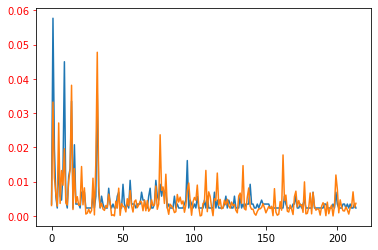

In [10]:
print(len(list(test_cor.keys())))
#print(test_cor.values())


test_cor_washed = { k:v for k, v in test_cor.items() if v > 1 } 

test_cor_in_train = {}

for k, v in test_cor_washed.items():
    if k in all_cor:
        test_cor_in_train[k] = all_cor[k]
    else:
        test_cor_in_train[k] = 0


import matplotlib.pyplot as plt

num_list = list(test_cor_washed.values())

#plt.yticks( [ 0.0001, 0.01 ], color='r')  # 设置y刻度
s = sum(num_list)
#print([ i  / s for i in num_list ])
plt.plot(range(len(num_list)), [ i  / sum(num_list) for i in num_list ],)# fc='r')

num_list_2 = list(test_cor_in_train.values())
#s2 = sum(num_list_2)
plt.plot(range(len(num_list_2)), [ i / sum(num_list_2) for i in num_list_2 ], )#bottom=num_list, fc='b')

plt.tick_params(axis='y',colors='red')

plt.savefig("familiar.png")

plt.show()


In [24]:
length = []
for key, values in cor_graph.items():

    length.append(len(values))
    if len(values) >= 60:
        print(key, values)


length.sort(reverse=True)
print(length)

菖 {'普': 0, '遭': 0, '营': 0, '直': 0, '富': 0, '算': 0, '百': 0, '葛': 0, '雷': 0, '害': 0, '晶': 0, '雪': 0, '鲁': 0, '警': 0, '蓄': 0, '喜': 0, '看': 0, '首': 0, '誓': 0, '暂': 0, '真': 0, '薄': 0, '蔓': 0, '着': 0, '董': 0, '享': 0, '掌': 0, '笔': 0, '者': 0, '副': 0, '毫': 0, '省': 0, '音': 0, '拿': 0, '署': 0, '落': 0, '信': 0, '置': 0, '言': 0, '革': 0, '童': 0, '肇': 0, '查': 0, '尊': 0, '囊': 0, '菁': 0, '蕾': 0, '章': 0, '霭': 0, '翼': 0, '事': 0, '寡': 0, '宴': 0, '莤': 0, '雾': 0, '苦': 0, '背': 0, '莒': 0, '籍': 0, '宣': 0, '青': 0, '蕃': 0, '暨': 0, '餐': 0, '苫': 0, '管': 0, '夏': 0, '霉': 0, '督': 0, '豆': 0, '震': 0}
熹 {'嘉': 0, '景': 0, '需': 0, '害': 0, '置': 0, '率': 0, '拿': 0, '靠': 0, '案': 0, '悬': 0, '蒙': 0, '鼐': 0, '喜': 0, '畜': 0, '纂': 0, '影': 0, '表': 0, '寄': 0, '幕': 0, '亭': 0, '毫': 0, '菁': 0, '善': 0, '甚': 0, '责': 0, '点': 0, '事': 0, '慕': 0, '蠢': 0, '蔓': 0, '海': 0, '享': 0, '寮': 0, '美': 0, '震': 0, '纛': 0, '桑': 0, '哥': 0, '煮': 0, '黛': 0, '盲': 0, '亮': 0, '筹': 0, '烹': 0, '信': 0, '叠': 0, '蒂': 0, '丢': 0, '蓄': 0, '囊': 0, '鬣': 0, '蕉': 0, '誓': 0, '募

In [14]:


valid14_cor, _ = get_all_cor(zip(valid14_source, valid14_target, valid14_ids))
valid_cor, _ = get_all_cor(zip(valid_source, valid_target, valid_ids))


#test_cor, test_cor_graph = get_all_cor(zip((valid14_source + valid_source), (valid14_target+valid_target), (valid14_ids + valid_ids) ) )

1062it [00:00, 37076.33it/s]
1100it [00:00, 121789.05it/s]


In [16]:
count = 0
t_cor = valid_cor
for key in t_cor.keys():
    if key in all_cor:
        count += 1
    else:
        print(key)
print(count / len(t_cor.keys()))

('户', '糊')
('的', '名')
('码', '么')
('么', '没')
('增', '噌')
('乍', '怎')
('枝', '只')
('鲙', '怪')
('卓', '著')
('暂', '占')
('床', '墙')
0.9762419006479481


In [16]:
#能被分词(长度>2的错误)
def count_wrongs(all_data_and_ids):  
    count = 0

    for data, ids in all_data_and_ids:

        if not ids:
            continue

        spans = [ i for i in jieba.cut(data) ]

        pointer_ids = 0
    
        pointer = 0

        for span in spans:

            pointer += len(span)
        
            tmp = ""

            if pointer >= ids[pointer_ids]:

                if not span.isdigit() and len(span) != 1:
                    tmp = span
                    count += 1
                else:
                    break

                pointer_ids += 1
                if pointer_ids >= len(ids):
                    break

    return count

t = count_wrongs(zip(valid_target, valid_ids))

print(t / len(valid_ids))

0.4027272727272727


In [11]:
#count 训练和test,要改的句子数量的样本不均衡
train_wrongs = 0
for i in train_ids:
    if i:
        train_wrongs += 1
print(train_wrongs / len(train_ids))

test_wrongs = 0
for j in valid_ids:
    if j:
        test_wrongs += 1
print(test_wrongs / len(valid_ids))

0.988043462962181
0.49272727272727274


In [10]:
t_test = count_wrongs(zip(valid_target, valid_ids))
print(t_test / len(valid_target))

0.4027272727272727


In [16]:
#let's check the dataset hit status
sys.path.append("/remote-home/xtzhang/CTC/CTC2021/SpecialEdition")

from core import get_lattice_dataset

datasets, vocabs, embeddings = get_lattice_dataset(dataset="sighan", path_head="/remote-home/xtzhang/CTC/CTC2021/SpecialEdition/") 


Loading Dataset !
Mon Dec 13 11:49:13 UTC 2021
Loading Lattice SigHan Dataset ...
Found 5601 out of 5671 words in the pre-training embedding.
Save cache to cache/sighan_lattice_test.


In [33]:
total_wrongs = 0
hit = 0

for i in range(len(train_target)):
    wrong_char_host =[]
    for j in range(len(train_target[i])):
        if train_target[i][j] != train_source[i][j]:
            wrong_char_host.append(train_target[i][j])

    arrows = datasets['train'][i]['lattice'][(datasets['train'][i]['seq_len'] - datasets['train'][i]['lex_nums']):]

    for wrong_char in wrong_char_host:
        if wrong_char in arrows:
            hit += 1

    total_wrongs += len(wrong_char_host)

print(total_wrongs, hit, hit / total_wrongs)


396220 284248 0.7173994245621119


In [34]:
total_wrongs = 0
hit = 0

for i in range(len(valid_target)):
    wrong_char_host =[]
    for j in range(len(valid_target[i])):
        if valid_target[i][j] != valid_source[i][j]:
            wrong_char_host.append(valid_target[i][j])

    arrows = datasets['test'][i]['lattice'][(datasets['test'][i]['seq_len'] - datasets['test'][i]['lex_nums']):]

    for wrong_char in wrong_char_host:
        if wrong_char in arrows:
            hit += 1

    total_wrongs += len(wrong_char_host)

print(total_wrongs, hit, hit / total_wrongs)

705 396 0.5617021276595745


In [23]:
"".join(datasets['train'][0]['lattice'][(datasets['train'][0]['seq_len'] - datasets['train'][0]['lex_nums']):])

'西信设看道到返基基基事师市节木兰立报保古光门富关管馆班结金塞蒙金塞吉新溪背迪多汉塔际机结上击几旧如时兴语连联班结金塞蒙金塞吉已忆引记己次七气汽期齐唐哈里'

In [10]:
print(train_source[0])
print(all_target[0])
print(all_ids[0])

tmp = [ i for i in jieba.cut(all_target[0])]

print(tmp)

result = ""

for target in all_target:
    tmp = [ i for i in jieba.cut(target) ]
    pointer = 0
    for j in tmp:
        pointer += len(j)
        if pointer >= all_ids[0][0]:
            result = j
            break
    break

print(result)



法新社记者报导,法国驻巴蓦斯坦大使杰拉德,以及巴国官员在巴基斯坦西北部的托克哈姆边界关卡迎接十月九日与两名巴基斯坦同业一起遭塔利班逮捕的裴哈。
法新社记者报导,法国驻巴基斯坦大使杰拉德,以及巴国官员在巴基斯坦西北部的托克哈姆边界关卡迎接十月九日与两名巴基斯坦同业一起遭塔利班逮捕的裴哈。
[12]
['法新社', '记者', '报导', ',', '法国', '驻', '巴基斯坦', '大使', '杰拉德', ',', '以及', '巴国', '官员', '在', '巴基斯坦', '西北部', '的', '托克', '哈姆', '边界', '关卡', '迎接', '十月', '九日', '与', '两名', '巴基斯坦', '同业', '一起', '遭', '塔利班', '逮捕', '的', '裴哈', '。']
巴基斯坦


In [11]:
from tqdm import tqdm
all_char_list = []
for sentence in tqdm(all_train + all_target):
    tmp = [j for j in sentence]
    all_char_list += tmp

all_char_set = list(set(all_char_list))
print(len(all_char_set))

write_to("my_char_dict.txt", "\n".join(all_char_set))


100%|██████████| 572716/572716 [00:04<00:00, 140392.13it/s]


5723


In [13]:
write_to("my_char_dict.txt", "\n".join(all_char_set))


In [23]:
def get_all_word(data, ids):
    """
            法新社记者报导,法国驻巴蓦斯坦大使杰拉德,以及巴国官员在巴基斯坦西北部的托克哈姆边界关卡迎接十月九日与两名巴基斯坦同业一起遭塔利班逮捕的裴哈。
    data : "法新社记者报导,法国驻巴基斯坦大使杰拉德,以及巴国官员在巴基斯坦西北部的托克哈姆边界关卡迎接十月九日与两名巴基斯坦同业一起遭塔利班逮捕的裴哈。"
    
    ids: [12]
    """
    if not ids:
        return ""

    spans = [ i for i in jieba.cut(data)]

    result = []

    pointer = 0

    for span in spans:   

        pointer += len(span)
        
        tmp = ""
        span = re.sub("\W*", "", span)
        if span and not span.isdigit() and len(span) != 1:
            tmp = span
            
        if tmp:
            result.append(tmp)
    return result


In [104]:
all_word_dict_plus = {}

from tqdm import tqdm

for data, id in tqdm(zip(all_target, all_ids)):
    for i in get_all_word(data, id):
        all_word_dict_plus[i] = 0

286358it [02:04, 2307.62it/s]


In [106]:
write_to("all_word_dict.txt", "\n".join([i for i in all_word_dict_plus.keys()]))

In [34]:
def get_magic_word(data, ids):
    """
            法新社记者报导,法国驻巴蓦斯坦大使杰拉德,以及巴国官员在巴基斯坦西北部的托克哈姆边界关卡迎接十月九日与两名巴基斯坦同业一起遭塔利班逮捕的裴哈。
    data : "法新社记者报导,法国驻巴基斯坦大使杰拉德,以及巴国官员在巴基斯坦西北部的托克哈姆边界关卡迎接十月九日与两名巴基斯坦同业一起遭塔利班逮捕的裴哈。"
    
    ids: [12]
    """
    #print(data, ids)
    if not ids:
        return ""

    spans = [ i for i in jieba.cut(data) ]
    
    result = []

    pointer_ids = 0
    
    pointer = 0
    #print(spans)
    for span in spans:

        pointer += len(span)
        
        tmp = ""
        if pointer > ids[pointer_ids]:
            span = re.sub("\W*", "", span)
            if span and not span.isdigit():
                tmp = span
            
            if tmp:
                result.append(tmp)

            pointer_ids += 1
            if pointer_ids >= len(ids):
                break
    
    return result


In [9]:
magic_dict = []

from tqdm import tqdm

for data, id in tqdm(zip(valid_target, valid_ids)):
    magic_dict += get_magic_word(data, id)


0it [00:00, ?it/s]


NameError: name 'get_magic_word' is not defined

In [8]:
for i in range(5):
    print(magic_dict[i])

NameError: name 'magic_dict' is not defined

In [23]:
c = 0
for i in valid_ids:
    if i :
        c += len(i)

print(c)

705


In [45]:
print(len(magic_dict))
count_word = 0
count_ =0

for i in magic_dict:
    #
    count_ += 1
    if len(i) > 1:
        count_word += 1
print(count_, count_word)


681
681 477


In [5]:
import re
import os
import sys
import json
import time

import jieba

sys.path.append("/remote-home/xtzhang/CTC/CTC2021/SpecialEdition")

from utils.io import read_csv, write_to, load_json

from utils.trie_utils import list2confusion_trie

confusion_set =  read_csv("/remote-home/xtzhang/CTC/CTC2021/SpecialEdition/data/confusion_set/confusion.txt")

confusion_dict = {}

for line in confusion_set:
	line = line.split(":")
	confusion_dict[line[0][0]] = line[-1]

all_word_list = read_csv("/remote-home/xtzhang/CTC/CTC2021/SpecialEdition/scripts/sighan/all_word_dict.txt")

def wash_n(all_word_list):
	return [ re.sub("\n", "", i) for i in all_word_list]

all_word_list = wash_n(all_word_list)
all_word_dict = {i:0 for i in all_word_list}
trie = list2confusion_trie(all_word_list, confusion_dict)

def super_get(sentence):
	trie.assign(sentence)
	trie.my_get_lexion()
	return trie.result

path = "./30wdict_utf8.txt"
dict_ = read_csv(path)
word_dict = {}
from tqdm import tqdm
for line in tqdm(dict_):
    word_dict[re.sub("\W*", "", line)] = 0


100%|██████████| 291269/291269 [00:01<00:00, 182904.69it/s]


In [12]:
matched_word_dict = []

for sentence in bert_missed_source:#valid_source:
    tmp = super_get(sentence)
    tmp = [ i[-1] for i in tmp]

    matched_word_dict += tmp

matched_word_dict = {i:0 for i in set(matched_word_dict)}

In [6]:
bert_missed = read_csv("bert_missed.txt")

In [16]:
print(len(bert_missed) / 3)

99.0


In [9]:
bert_missed_source = []
i = 0
for s in bert_missed:
    if i % 3 == 0:
        bert_missed_source.append(s)
    i+= 1 


In [18]:
print(len(bert_missed_source))

99


In [10]:
need = ['小鸡', '记得', '糊涂', '订位', '怎么', '面见', '弟弟', '炒饭', '汉字', '那店', '八点钟', '这样', '迟到', '很饱', '迟到', '迟到', '安静', '一点', '妈妈', '吃饭', '时候', '希望', '简讯', '那里', '诉取', '不半工', '哪些', '上半', '上半', '轻松', '消息', '与此同时', '这种', '权利', '优家', '失业', '心情', '减少', '著迷', '家长', '唠叨', '影响', '睡觉', '拜托', '存到', '年轻', '威胁', '我们', '回覆', '墙壁', '他们', '这是', '现在', '很忙', '不怎么', '试试看', '录影机', '哪个', '哪个', '不是', '再加', '该不该', '看著', '看著', '有装', '教书', '记录']

In [15]:
len(need)

67

In [14]:
print("List:")
count = 0
count_super = 0
missed = []
for word in need:#magic_dict:
    if word in matched_word_dict:
        count_super += 1
    if word in all_word_dict and word in matched_word_dict:
        count += 1
    if len(word) != 1 and word not in matched_word_dict:
        missed.append(word)

print("Missed :", len(missed))
print(count_super, count)

print("Set:")
count = 0
count_super = 0
missed = []
for word in list(set(need)):#list(set(magic_dict)):
    if word in matched_word_dict:
        count_super += 1
    if word in all_word_dict and word in matched_word_dict:
        count += 1
    if len(word) != 1 and word not in matched_word_dict:
        missed.append(word)

print("Missed :", len(missed))
print(count_super, count)

List:
Missed : 17
50 50
Set:
Missed : 16
46 46


In [47]:
print(len(valid_target))

1100


In [ ]:
print(train_source[:15], all_target[:15])

['法新社记者报导,法国驻巴蓦斯坦大使杰拉德,以及巴国官员在巴基斯坦西北部的托克哈姆边界关卡迎接十月九日与两名巴基斯坦同业一起遭塔利班逮捕的裴哈。', '冰皂与挪威北部间数百公鳕宽的区域均为危险区。', '孟加拉官员及撮导今天说,过去两周至少有四十七人,大多为儿童,死于污染与季节变化所引发的呼吸道疾病及腹泻。', '本月十一日,西班牙首都马德里发生严重伤亡的爆炸事件,造咸两百人丧生和一千四百余人轻重伤。', '毕兰德拉对王室统治的见解,鹿信与新王完全泪反。', '玩游戏以及阅读电子枢方面。', '华府市鲁金斯研究所政治分析家海斯说,未来的国家元首面对国会时应更加审慎。', '但是,撮导推测,金正日可能已前往西伯利亚伊尔库次克途中,准备在当地与陇罗斯总统蒲亭举行会谈。', '他目前于誓方戒护下在医院接受治疗。', '布希上周三出席全代会时说,在阿富汗境内与美国并肩作战的国家约苜四十个,而在伊拉克境内则有三十个。', '差了几次牌子也无计于事。', '她说,这艘船预定在科林斯卸载一万两千公吨的基改大豆和七干公吨的墓改玉米。', '即将在一个月后离任的柯林顿,此次是他以美国总统身分第三度也是最后一次赴北爱从事官方访问。他在动荡不安的北爱,鼓利当地人民勿放气对持久和平方案的最求。', '在金拥春发表这项演说前,华盛顿当局正针对北韩杯葛朝鲜半岛核子问题六方会谈采取越来越强硬的立场。', '哈利在着名的伊顿学院修习了艺术和地理课程,成绩分别为和。级课程的评分由到,以为最高分。他的父亲查尔斯王子说:对哈利,我感到非常骄傲他很用公准备考试,我对今天的成绩感到很高兴。'] ['法新社记者报导,法国驻巴基斯坦大使杰拉德,以及巴国官员在巴基斯坦西北部的托克哈姆边界关卡迎接十月九日与两名巴基斯坦同业一起遭塔利班逮捕的裴哈。', '冰岛与挪威北部间数百公里宽的区域均为危险区。', '孟加拉官员及报导今天说,过去两周至少有四十七人,大多为儿童,死于污染与季节变化所引发的呼吸道疾病及腹泻。', '本月十一日,西班牙首都马德里发生严重伤亡的爆炸事件,造成两百人丧生和一千四百余人轻重伤。', '毕兰德拉对王室统治的见解,咸信与新王完全相反。', '玩游戏以及阅读电子书方面。', '华府布鲁金斯研究所政治分析家海斯说,未来的国家元首面对国会时应更加审慎。', '但是,报导推测,金正日可能已前往西伯利亚

In [95]:
print(all_ids[:15])

[[12], [1, 11], [6], [27], [13, 20], [9], [2], [3, 34], [4], [30], [0, 8], [27, 31], [55, 62, 71], [2], [68]]


In [104]:
print(magic_dict[:15])

['巴基斯坦', '冰岛', '咸信', '相反', '电子书', '华府', '报导', '俄罗斯', '基改', '当地', '持久和平', '金永春']


In [125]:
print(len(magic_dict))

42694


In [109]:
write_to("./magic_dict.txt", "\n".join(magic_dict))

In [110]:
def dict2d(word_dict):
    """
    """

    d = {}

    for word in word_dict:
        key = len(word)
        if key in d:
            d[key].append(word)
        else:
            d[key] = [word]
    
    return d


In [12]:
magic_dict = read_csv("./magic_dict.txt")

In [13]:
def wash(magic_dict):
    result = []
    for i in magic_dict:
        tmp = re.sub("\n", "", i)
        if tmp:
            result.append(tmp)
    return result

magic_dict = wash(magic_dict)

In [14]:
def get_better_dict(word_dict):
    d = {}

    for word in word_dict:
        key_1 = len(word)

        #small -> ignore length==2
        if len(word) == 2:
            continue

        if key_1 in d.keys():
            key_2 = word[0]
            key_3 = word[-1]

            if key_2 in d[key_1][0].keys():
                d[key_1][0][key_2].append(word)
            else:
                d[key_1][0][key_2] = [word]

            if key_3 in d[key_1][-1].keys():
                d[key_1][-1][key_3].append(word)
            else:
                d[key_1][-1][key_3] = [word]
        else:
            d[key_1] = {0:{},-1:{} }
            key_2 = word[0]
            key_3 = word[-1]
            
            d[key_1][0][key_2] = [word]

            d[key_1][-1][key_3] = [word]
            
    return d



In [15]:
d = get_better_dict(magic_dict)

In [16]:
d[3]
d.keys()

dict_keys([3, 6, 4, 5, 7, 8, 9, 11, 10, 13])

In [21]:
def better_match(data, d):

    result, map_info = [], []

    index = 0 

    #print(data)

    for word in data:

        if len(word) not in d.keys():
            index += len(word) 
            continue

        length = len(word)

        key_left, key_right = word[0], word[-1]

        if key_left in d[length][0]:
            d_left = d[length][0][word[0]]
        else:
            d_left = {}

        if key_right in d[length][-1]:
            d_right = d[length][-1][word[-1]]
        else:
            d_right = {}

        pair = []

        for query in d_right:
            count = 0
            
            for i in range(len(query)):
                if count > 1:
                    break
                elif query[i] == word[i]:
                    pass
                else:
                    count += 1
            if count == 1:
                pair.append(query)
                map_info.append("$".join(list(map(str, range(index, index+len(word))))))
            
        for query in d_left:
            count = 0
            
            for i in range(len(query)):
                if count > 1:
                    break
                elif query[i] == word[i]:
                    pass
                else:
                    count += 1
            if count == 1:
                if query not in pair:
                    pair.append(query)
                    map_info.append("$".join(list(map(str, range(index, index+len(word))))))

        index += length
        result += pair
        
    return result, map_info


In [22]:
def air_preprocess(sentence):
    import re
    import jieba
    return [ i for i in jieba.cut(sentence) if len(i) >= 1] 


In [23]:
print(valid_source[0])
better_match(air_preprocess(valid_source[0]), d)

你好!我是张爱文。


(['张书文'], ['5$6$7'])

In [24]:
result = []

import time

start_time = time.time()

from tqdm import tqdm

for data in tqdm(train_source):
    result.append(better_match(light_preprocess(data), d))    
    
result_valid14 = []

for data in tqdm(valid14_source):
    result_valid14.append(better_match(light_preprocess(data), d))  

result_valid = []

for data in tqdm(valid_source):
    result_valid.append(better_match(light_preprocess(data), d))  

print(time.time()-start_time)

100%|██████████| 1100/1100 [00:00<00:00, 3280.67it/s]

179.5640344619751


In [20]:
result[0]

(['中新社',
  '法新电',
  '罗斯坦',
  '杜斯坦',
  '康斯坦',
  '普拉德',
  '巴勒斯坦',
  '东北部',
  '西南部',
  '巴勒斯坦',
  '塔利亚'],
 ['0$1$2',
  '0$1$2',
  '11$12$13',
  '11$12$13',
  '11$12$13',
  '16$17$18',
  '25$26$27$28',
  '29$30$31',
  '29$30$31',
  '48$49$50$51',
  '56$57$58'])

In [21]:
sum(map(len, result[2]))
sum(map(lambda x:sum(map(len, x)), result)) / len(result)

6.586109586341821

In [22]:
print(result_valid14[:5]) 
print(result_valid14[:5])

[([], []), ([], []), (['联合体', '联合党', '联合会', '联合报', '对产龄', '生产率', '生育力', '生育期'], ['2$3$4', '2$3$4', '2$3$4', '2$3$4', '26$27$28', '33$34$35', '33$34$35', '33$34$35']), (['为什么'], ['6$7$8']), (['联合体', '联合党', '联合会', '联合报', '生产率', '生育力', '生育期'], ['2$3$4', '2$3$4', '2$3$4', '2$3$4', '33$34$35', '33$34$35', '33$34$35'])]
[([], []), ([], []), (['联合体', '联合党', '联合会', '联合报', '对产龄', '生产率', '生育力', '生育期'], ['2$3$4', '2$3$4', '2$3$4', '2$3$4', '26$27$28', '33$34$35', '33$34$35', '33$34$35']), (['为什么'], ['6$7$8']), (['联合体', '联合党', '联合会', '联合报', '生产率', '生育力', '生育期'], ['2$3$4', '2$3$4', '2$3$4', '2$3$4', '33$34$35', '33$34$35', '33$34$35'])]


In [23]:
print(result_valid[:5]) 
print(result_valid[:5])

[(['张书文'], ['2$3$4']), (['上个星期'], ['0$1$2$3']), ([], []), ([], []), ([], [])]
[(['张书文'], ['2$3$4']), (['上个星期'], ['0$1$2$3']), ([], []), ([], []), ([], [])]


In [24]:
" ".join(list(map("".join, result[6][1])))

'2$3$4$5 6$7$8 6$7$8 6$7$8 6$7$8 6$7$8 6$7$8 11$12$13'

In [27]:
print(len(result))

284196


In [26]:

def app(train_source, result):
    new = []
    for i in range(len(train_source)):
        tmp = train_source[i] + "\n" + " ".join(result[i][0]) + "," + " ".join(result[i][1])
        new.append(tmp)
    return new

train_magic_source, valid14_magic_source, valid_magic_source = app(train_source, result), app(valid14_source, result_valid14), app(valid_source, result_valid)   

In [26]:
print(train_magic_source[0])
print(valid14_magic_source[0])
print(valid_magic_source[0])

法新社记者报导,法国驻巴蓦斯坦大使杰拉德,以及巴国官员在巴基斯坦西北部的托克哈姆边界关卡迎接十月九日与两名巴基斯坦同业一起遭塔利班逮捕的裴哈。
中新社 法新电 罗斯坦 杜斯坦 康斯坦 普拉德 巴勒斯坦 东北部 西南部 巴勒斯坦 塔利亚,0$1$2 0$1$2 11$12$13 11$12$13 11$12$13 16$17$18 25$26$27$28 29$30$31 29$30$31 48$49$50$51 56$57$58
相对的、每位产龄妇女的生育婴儿个数却特续下滑。这表示全球出现适合年龄生育的妇女不想生育的现象。
,
你好!我是张爱文。
张书文,2$3$4


In [25]:

write_to("/remote-home/xtzhang/CTC/CTC2021/SpecialEdition/data/rawdata/sighan/lattice/train.src", "\n".join(train_magic_source))
write_to("/remote-home/xtzhang/CTC/CTC2021/SpecialEdition/data/rawdata/sighan/lattice/train.tgt", "\n".join(train_target))

write_to("/remote-home/xtzhang/CTC/CTC2021/SpecialEdition/data/rawdata/sighan/lattice/valid14.src", "\n".join(valid14_magic_source))
write_to("/remote-home/xtzhang/CTC/CTC2021/SpecialEdition/data/rawdata/sighan/lattice/valid14.tgt", "\n".join(valid14_target))

write_to("/remote-home/xtzhang/CTC/CTC2021/SpecialEdition/data/rawdata/sighan/lattice/test.src", "\n".join(valid_magic_source))
write_to("/remote-home/xtzhang/CTC/CTC2021/SpecialEdition/data/rawdata/sighan/lattice/test.tgt", "\n".join(valid_target))

write_to("/remote-home/xtzhang/CTC/CTC2021/SpecialEdition/data/rawdata/sighan/lattice/valid.src", "\n".join(valid_magic_source[500:]))
write_to("/remote-home/xtzhang/CTC/CTC2021/SpecialEdition/data/rawdata/sighan/lattice/valid.tgt", "\n".join(valid_target[500:]))


NameError: name 'train_magic_source' is not defined